<a href="https://colab.research.google.com/github/farshokat/plate-/blob/main/KNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ignore warning 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import numpy as np
import cv2
from sklearn.svm import SVC
from sklearn.model_selection import  cross_val_score
import pickle
from sklearn.externals.joblib import dump, load

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dataset_paths = glob.glob("/content/drive/MyDrive/Data/Data/Train_character/*/*.jpg")

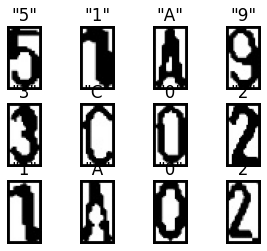

In [ ]:
cols=4
rows=3
fig = plt.figure(figsize=(5,4))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)

# create a random list of images will be displayed
np.random.seed(45)
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))

# Plot image
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

#plt.savefig("Visualize_dataset.jpg",dpi=300)

In [ ]:
X=[]

for image_path in dataset_paths:
  image=load_img(image_path,target_size=(24,44))
  image = cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2GRAY)
  thresh, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
  image = cv2.resize(image,(24,44))
  #image = image
  image = image.astype('float')
  #print(image.shape)
  X.append(image.reshape(-1,1))
 
#print(X[1])
X=np.array(X)
  #image.shape
  #print(image.shape)

X = X.reshape(X.shape[:2])
print(X.shape)



(1892, 1056)


In [ ]:
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  labels.append(label)

#X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))


# perform one-hot encoding on the labels
#lb = LabelEncoder()
#lb.fit(labels)
#labels = lb.transform(labels)
#y = to_categorical(labels)

# save label file so we can use in another script
len(labels)

[INFO] Find 1892 images with 17 classes


1892

In [ ]:
# split 10% of data as validation set
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=.3)

In [ ]:
# data augumentation
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              fill_mode="nearest"
                              )

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
print("Training ended")

Training ended


In [ ]:
test = model.score(X_test, y_test)
print(test)

0.9894366197183099


In [ ]:
def find_contours(dimensions, img) :


    # Find all contours in the image
    cntrs,hierarchy= cv2.findContours(img.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    

    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:20]

    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)

    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
    
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [ ]:
def segment_characters(image) :

    #Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    #*plt.imshow(img_lp)
    #*plt.show()
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    plt.imshow(img_gray_lp)
    #*plt.show()
    _, img_binary_lp = cv2.threshold(img_gray_lp, 255, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #*plt.imshow(img_binary_lp)
    #*plt.show()
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    #*plt.imshow(img_binary_lp)
    #*plt.show()
    img_binary_lp1 = cv2.dilate(img_binary_lp,(3,3))
    #plt.show(img_binary_lp1)
    #plt.show()
    #plt.imshow(img_binary_lp)
    #img_binary_lp = cv2.resize(image, (333, 75))

    LP_WIDTH = img_binary_lp1.shape[0]
    LP_HEIGHT = img_binary_lp1.shape[1]

    # Make borders white
    img_binary_lp1[0:3,:] = 0
    img_binary_lp1[:,0:3] = 0
    img_binary_lp1[72:75,:] = 0
    img_binary_lp1[:,330:333] = 0

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/9,
                       LP_WIDTH/1,
                       LP_HEIGHT/9,
                       LP_HEIGHT/1]
    plt.imshow(img_binary_lp1, cmap='gray')
    plt.show()
    #cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp1)

    return char_list

   #def bwareaopen(image, areaPixels):
        #image = img_binary_lp1.copy()
        
        #for idx in np.arange(len(contours)):
            #area = cv2.contourArea(contour[idx])
            #if (area >= 0 and area <= areaPixels):
                #cv2.drawContour(image, contour, idx, (0,0,0), -1)
        #return img_binary_lp1

In [ ]:
cv_img = []
for img in glob.glob("/content/drive/MyDrive/Data/Data/image test/*.jpg"):
    name_img=img.split("/")[-1] 
    n= cv2.imread(img,1)
    cv_img.append(n)

In [ ]:
len(cv_img)

70

In [ ]:
image = cv_img[54].copy()
#plt.imshow(image)

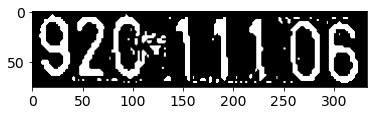

In [ ]:
char = segment_characters(image)

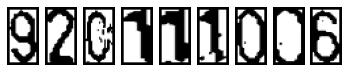

In [ ]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
#print(len(char))

8


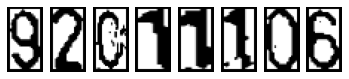

In [ ]:
listchar = []
for i in range(len(char)):
    if np.sum(char[i] == 0) > np.sum(char[i] == 255):
        listchar.append(char[i])
for i in range(len(listchar)):
    plt.subplot(1, len(listchar), i+1)
    plt.imshow(listchar[i], cmap='gray')
    plt.axis('off')
print(len(listchar))

8


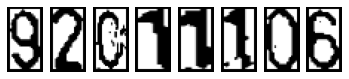

In [ ]:
listfinal = []
if len(char) == 8:
    listfinal = char.copy()
    for i in range(len(listfinal)):
        plt.subplot(1, len(listfinal), i+1)
        plt.imshow(listfinal[i], cmap='gray')
        plt.axis('off')
if len(char) != 8 and len(listchar) == 8:
    listfinal = listchar.copy()
for i in range(len(listfinal)):
    plt.subplot(1, len(listfinal), i+1)
    plt.imshow(listfinal[i], cmap='gray')
    plt.axis('off')
print(len(listfinal))

In [ ]:
X1=[]

for i in range(0, len(listfinal)):
  image = listfinal[i]
  #image=load_img(listfinal,target_size=(24,44))
  #image = np.full((100,80,3), 12, np.uint8)
  #image = cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2GRAY)
  #thresh, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
  image = cv2.resize(image,(24,44))
  #image = image
  image = image.astype('float')
  #print(image.shape)
  X1.append(image.reshape(-1,1))
#*print(X1[1]) 
#print(X[1])
X1=np.array(X1)
  #image.shape
  #print(image.shape)
X1 = X1.reshape(X1.shape[:2])
#*print(X1.shape)

In [ ]:
y1 = model.predict(X1)
print(y1)

['9' '2' '0' '1' '1' '1' '0' '6']
